# Set up

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
print(torch.version.cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'

True
NVIDIA GeForce RTX 4090
12.1


In [3]:
import pandas as pd
import utility_functions as utils

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np

In [4]:
#%% import

import os
from collections import defaultdict
import sys

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import copy
import numpy as np
import numpy.random
from numpy.fft import fft as fft
from numpy.fft import ifft as ifft
import pickle
from sklearn.linear_model import PoissonRegressor
from sklearn.model_selection import KFold
import scipy.stats
from scipy.stats import wilcoxon, chi2
import scipy.interpolate 
import scipy.signal
from scipy import linalg
from scipy.special import rel_entr
from tqdm import tqdm

import statsmodels.api as sm
import statsmodels.genmod.generalized_linear_model as smm

import utility_functions as utils
import GLM
from DataLoader import Allen_dataset
# from GLM import FC_GPFA

import torch
from torch.autograd import Variable
from torch.nn import functional as F
import torch.nn as nn
import torch.optim as optim

# Decoder: time-varying and trial-varying projecting matrix (pytorch version)

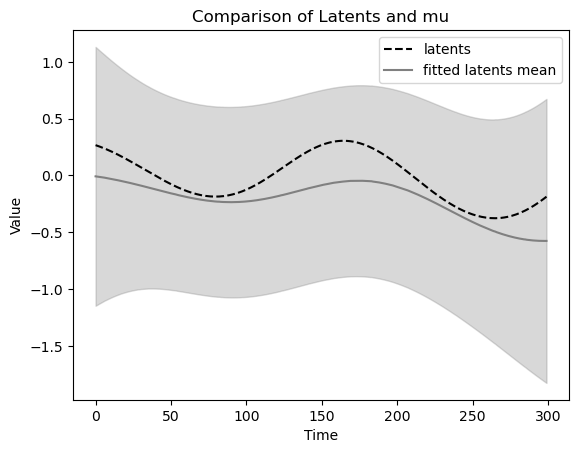

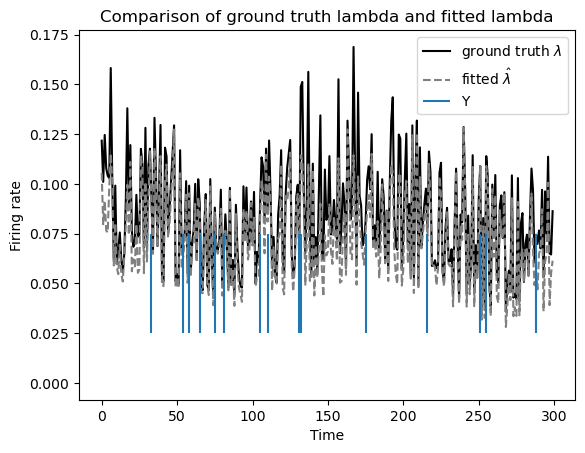

In [5]:
from GLM import gpfa_poisson_fix_weights, make_4d_diagonal, get_K
from GLM import conv_new as conv

# Parameters for data generation
ntrial = 1000  # Number of trials
nt = 300    # Number of time bins
nneuron = 2 # Number of neurons
nlatent = 1 # Number of latent variables

# Generate covariance matrix K for the latent variables
K = get_K(nt=nt, L=100)

# Generate latent variables from a multivariate normal distribution
np.random.seed(0)
latents = np.random.multivariate_normal(np.zeros(nt), K, (ntrial, nlatent))
# latents = np.swapaxes(latents, 1, 2)

# Known weights matrix
np.random.seed(0)
# weights = np.abs(np.random.rand(nneuron, nlatent))
# weights = np.repeat(weights[np.newaxis, :, :, np.newaxis], ntrial, axis=0)
# weights = np.repeat(weights, nt, axis=-1)
weights = (np.random.rand(ntrial, nneuron, nlatent, nt))
weights_wrong = weights
# weights_wrong = 2*(np.random.rand(ntrial, nneuron, nlatent, nt))
bias = np.random.rand(ntrial, nneuron, nt)-3
bias_wrong = bias
# bias_wrong = np.random.rand(ntrial, nneuron, nt)+4

# Generate observed spike counts Y
# Calculate the mean of the Poisson distribution
lambd = np.exp(np.einsum('mnlt,mlt->mnt', weights, latents)+bias)
# Sample Y from Poisson distribution
Y = np.random.poisson(lambd)

# Call the function with tensors
mu, hessian, fitted_lambd, loss = gpfa_poisson_fix_weights(torch.from_numpy(Y).float().to(device), 
                                                 torch.from_numpy(weights_wrong).float().to(device), 
                                                 torch.from_numpy(K).float().to(device), 
                                                 bias=torch.from_numpy(bias_wrong).float().to(device),
                                                 max_iter=1000, 
                                                 lr=1e-1,
                                                 verbose=False)

# Conversion for plotting (PyTorch tensor to NumPy array)
mu = mu.cpu().numpy()
hessian = hessian.cpu().numpy()
fitted_lambd = fitted_lambd.cpu().numpy()

# Plotting code remains
trial_to_plot = 5
plt.figure()
plt.plot(latents[trial_to_plot, 0, :], '--', label='latents', color='k')
std = np.sqrt(np.diagonal(-np.linalg.inv(hessian), axis1=-2, axis2=-1))
lower_bound = mu - 1.96 * std
upper_bound = mu + 1.96 * std
plt.plot(mu[trial_to_plot, 0, :], label='fitted latents mean', color='grey')
plt.fill_between(range(nt), lower_bound[trial_to_plot, 0, :], upper_bound[trial_to_plot, 0, :], alpha=0.3, color='grey')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Comparison of Latents and mu')
plt.legend()
plt.show()


plt.figure()
plt.plot(lambd[trial_to_plot, 0, :], color='k', label='ground truth $\lambda$')
plt.plot(fitted_lambd[trial_to_plot, 0, :], '--', color='grey', label='fitted $\hat{\lambda}$')
plt.eventplot(np.where(Y[0, 0, :]>0), label='Y', lineoffsets=0.05, linelengths=0.05)
plt.xlabel('Time')
plt.ylabel('Firing rate')
plt.title('Comparison of ground truth lambda and fitted lambda')
plt.legend()
plt.show()


# Encoder
When at a point in the parameter space of the encoder, the decoder first generate the variational posterior, then taking the posterior as fixed values, perform gradient descent with regard to the encoder parameters, taking ELBO as the objective function. 
In the below code, I want to make sure when the latent is correct, if the weight converge to ground truth. 

```
latent (ntrial, nlatent, nt) 
--W--> 
communication subspace (ntrial, narea, narea, ns, nt)

coefficients of basis (:, narea, narea, ns, nb, :)
```

# Generate simulated spike trains from GLM neurons

21.0


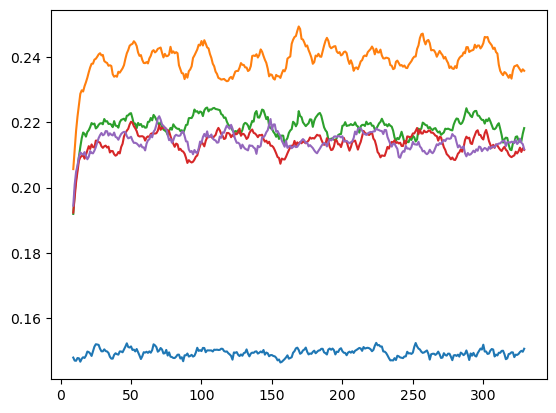

In [7]:
### Generate data
torch.manual_seed(0)
np.random.seed(0)

MAX_FIRING_RATE = 10
gt_neuron_params = {'baseline_fr':0.15, 'ntrial':1000, 'narea':5, 'nneuron_area':5, 
                    'nt':300, 'npadding':30}
nneuron = gt_neuron_params['narea']*gt_neuron_params['nneuron_area']
nneuron_area = gt_neuron_params['nneuron_area']
narea = gt_neuron_params['narea']

coupling_filter_params = {'peaks_max':10.2, 'num':3, 'nonlinear':0.5}
basis_coupling = GLM.make_pillow_basis(**coupling_filter_params)
basis_coupling = basis_coupling[:,:1]

max_histories = basis_coupling.shape[0]
nt = gt_neuron_params['nt'] + gt_neuron_params['npadding']
coupling_mat = np.zeros((max_histories, nneuron, nneuron))
baseline_mat = np.zeros((nt, nneuron))
spikes = np.zeros((ntrial, nneuron, nt))
log_firing_rate_rcd = np.zeros((ntrial, nneuron, nt))

### Generate coupling matrix
for jarea in range(gt_neuron_params['narea']):
    baseline_mat[:, jarea*nneuron_area:(jarea+1)*nneuron_area] = np.log(gt_neuron_params['baseline_fr'])
    # baseline_mat[:, jarea*nneuron_area:(jarea+1)*nneuron_area] = baseline_fr*np.random.rand(nt, nneuron_area)
    for iarea in range(narea):
        # if jarea == iarea+1 and jarea in [1]:
        if iarea == 0 and jarea != iarea:
            coupling_mat[:, iarea*nneuron_area:(iarea+1)*nneuron_area, jarea*nneuron_area:(jarea+1)*nneuron_area] \
                = np.flip(1*basis_coupling[:,0])[:, np.newaxis, np.newaxis]/nneuron_area

### Generate time-varying coupling strength coefficients
nlatent = 1
gt_latent_params = {'sigma2':4, 'nlatent':nlatent, 'offset':0.5, 'L':200}
project_w = (np.random.uniform(low=-1, high=1, size=(narea, narea, nlatent)))
project_w *= 2/np.sqrt(np.sum(project_w**2))
K_gt = get_K(nt=nt, L=gt_latent_params['L'], sigma2=gt_latent_params['sigma2'])
latents = np.random.multivariate_normal(np.zeros(nt), K_gt, (ntrial, nlatent))
time_varying_coef = np.einsum('ijl, mlt -> ijmt', project_w, latents) + gt_latent_params['offset']
# time_varying_coef = np.einsum('...i, ijk -> ...jk', project_w, latents)


### Rescale the time varying coefficients to have mean value of 1
### Rescale the coupling matrix to have maximum absolute value of 1
# print(abs(coupling_mat).max())
# rescale = 1/abs(coupling_mat).max()
# coupling_mat *= rescale
# time_varying_coef: narea x narea x ntrial x nt

### Generate spikes
for itrial in range(ntrial):
    spikes_single_trial = np.zeros((nt, nneuron, 1))
    log_firing_rate = copy.copy(baseline_mat[:,:,np.newaxis])
    spikes_single_trial[0,:,0] = np.random.poisson(np.exp(log_firing_rate[0,:,0]))

    for t in range(1, nt):
        nhistories = min(t, max_histories)
        temp_log_firing_rate = (coupling_mat[-nhistories:, :, :] \
            * np.kron(time_varying_coef[:,:,itrial,t][np.newaxis,:,:], np.ones((nneuron_area, nneuron_area))) \
                * spikes_single_trial[(t-nhistories):(t), :, :]).sum(axis=(0, 1))
        log_firing_rate[t,:,0] += temp_log_firing_rate
        log_firing_rate[t,:,0] = np.minimum(log_firing_rate[t,:,0], MAX_FIRING_RATE)
        spikes_single_trial[t,:,0] = np.random.poisson(np.exp(log_firing_rate[t,:,0]))
        # spikes_single_trial[t,:,0] = np.exp(log_firing_rate[t,:,0])

    log_firing_rate = log_firing_rate.squeeze()
    spikes_single_trial = spikes_single_trial.squeeze()
    spikes[itrial, :, :] = spikes_single_trial.T
    log_firing_rate_rcd[itrial, :, :] = log_firing_rate.T
    
print(spikes.max())

spikes_full = spikes
spikes = [spikes_full[:,iarea*nneuron_area:(iarea+1)*nneuron_area,:] for iarea in range(narea)]

import pandas as pd
window_size = 10
for i in range(narea):
    smoothed_spikes = pd.Series(spikes[i].mean(axis=(0,1))).rolling(window=window_size).mean()
    plt.plot(smoothed_spikes)

# Build the model

change line 74 75 88 89 (specifying baseline and offset) makes the model able to converge to ground truth. Wonder what's causing this, nonidentification or optimization problem? 

In [57]:
# Input needed: spikes, narea, nneuron_area

# Define the model
class FC_GPFA(nn.Module):
    def __init__(self, spikes, latents=None, nlatent=None, npadding=None, K=None, initialized_with_gt=False, device='cpu'):
            """
            Initialize the FC_GPFC class.

            Parameters:
            spikes (list): A list of spike data for each population.
            latents (ndarray, optional): Latent variables. Defaults to None.
            fix_latent (bool, optional): Flag indicating whether to fix the latent variables. Defaults to False.
            nlatent (int, optional): Number of latent variables. Defaults to None.
            npadding (int, optional): Number of padding time points. Defaults to None.
            """
            
            super(FC_GPFA, self).__init__()
            self.device = device
            self.spikes = [torch.tensor(spike, dtype=torch.float32, device=self.device) for spike in spikes]
            self.spikes_full = torch.concat(self.spikes, axis=1)
            self.npop = len(self.spikes)
            self.ntrial, _, self.nt = self.spikes[0].shape
            self.npadding = npadding
            self.nt -= self.npadding
            self.nneuron = [spike.shape[1] for spike in spikes]
            self.tot_neuron = sum(self.nneuron)
            self.accnneuron = [0]+np.cumsum(self.nneuron).tolist()
            self.mu = None
            self.hessian = None
            
            if latents is not None:
                self.nlatent = latents.shape[1]
                self.latents = torch.tensor(latents, dtype=torch.float32, device=self.device)
            else:
                self.K = torch.from_numpy(K).float().to(self.device)
                self.nlatent = nlatent
                self.latents = torch.zeros(self.ntrial, self.nlatent, self.nt, dtype=torch.float32, device=self.device)
                # raise ValueError("Unfinished")
            
            # Initialize the latents_readout and time_varying_coef_offset
            ###############################################
            if initialized_with_gt:
                # self.latents_readout = nn.Parameter(torch.from_numpy(project_w).float().to(device))
                self.latents_readout = nn.Parameter(torch.zeros(self.npop, self.npop, self.nlatent, device=self.device))
                with torch.no_grad():
                    for i in range(self.npop):
                        self.latents_readout[0,i,0] = project_w[0,i,0]
                        
                self.time_varying_coef_offset = nn.Parameter(torch.zeros(self.npop, self.npop, 1, 1, device=device))
                with torch.no_grad():
                    for i in range(self.npop):
                        self.time_varying_coef_offset[0,i,0,0] = gt_latent_params['offset']
            else:
                self.latents_readout = nn.Parameter(0.01 * (torch.randn(self.npop, self.npop, self.nlatent, device=self.device) * 2 - 1))
                self.time_varying_coef_offset = nn.Parameter(0.1 * (torch.randn(self.npop, self.npop, 1, 1, device=self.device) * 2 - 1))
            ###############################################
            
            coupling_filter_params = {'peaks_max':10.2, 'num':3, 'nonlinear':0.5}
            basis_coupling = GLM.make_pillow_basis(**coupling_filter_params)
            basis_coupling = basis_coupling[:,:1]
            self.basis_coupling = torch.tensor(basis_coupling, dtype=torch.float32, device=self.device)
            
            self.beta_coupling = nn.ModuleList([
                nn.ParameterList([
                    nn.Parameter(0.2*torch.ones(basis_coupling.shape[1], self.nneuron[ipop], self.nneuron[jpop], 
                                              device=self.device))
                    for jpop in range(self.npop)])
                for ipop in range(self.npop)])
            
            self.beta_inhomo = nn.ParameterList([
                nn.Parameter(torch.unsqueeze(torch.unsqueeze(self.spikes[jpop].mean(axis=(0,2)), 0), 2))
                for jpop in range(self.npop)])
            
            self.coupling_filters = [[torch.einsum('ij,jkl->ikl', self.basis_coupling, self.beta_coupling[ipop][jpop]).transpose(0,1)
                for jpop in range(self.npop)] for ipop in range(self.npop)]
        
    def normalize(self):
        # Normalize the nonidentifiable parameters
        with torch.no_grad():

            for ipop in range(self.npop):
                for jpop in range(self.npop):
                    # beta_coupling need to have unit norm and overall positive
                    ratio = (1/torch.sqrt(self.beta_coupling[ipop][jpop].pow(2).sum()))**(1e-1)\
                        *(1 if self.beta_coupling[ipop][jpop].mean()>=0 else -1)
                    assert ratio != 0, ValueError("Ratio shouldn't be zero when normalizing beta_coupling.")
                    self.beta_coupling[ipop][jpop] *= ratio
                    self.latents_readout[ipop, jpop, :] *= 1/ratio
                    self.time_varying_coef_offset[ipop, jpop, :,:] *= 1/ratio
                    
            # latents_readout need to have unit norm
            # self.latents_readout *= 1/torch.sqrt(self.latents_readout.pow(2).sum())


    
    def get_ci(self, alpha=0.05):
        self.std = torch.sqrt(torch.diagonal(-torch.linalg.inv(self.hessian), dim1=-2, dim2=-1))
        z = scipy.stats.norm.ppf(1-alpha/2)
        self.lower_bound = self.mu - z * self.std
        self.upper_bound = self.mu + z * self.std
    
    def forward(self):
        
        # basis_coupling, beta_coupling -> coupling_filters
        self.coupling_filters = [[torch.einsum('ab,bij->aij', self.basis_coupling, self.beta_coupling[ipop][jpop]).transpose(0,1)
            for jpop in range(self.npop)] for ipop in range(self.npop)]
        # Generate time-varying coupling strength coefficients
        # self.time_varying_coef = torch.einsum('ijl,lmt -> ijmt', self.latents_readout, self.latents) + gt_latent_params['offset']
        self.time_varying_coef = torch.einsum('ijl,mlt -> ijmt', self.latents_readout, self.latents) + self.time_varying_coef_offset

        # coupling_filters, spike trains, time_varying_coef (total coupling effects) -> log_firing_rate
        self.log_firing_rate = [torch.zeros(self.ntrial, self.nneuron[jpop], self.nt, device=self.device) 
                                for jpop in range(self.npop)]
        for jpop in range(self.npop):
            for ipop in range(self.npop):
                if ipop == jpop:
                    continue
                self.log_firing_rate[jpop] += conv(self.spikes[ipop], self.coupling_filters[ipop][jpop], 
                    npadding=self.npadding).sum(axis=1) *torch.unsqueeze(self.time_varying_coef[ipop, jpop, :, :], 1)
        
        # inhomo -> log_firing_rate
        for jpop in range(self.npop):
            ###############################################
            self.log_firing_rate[jpop] += self.beta_inhomo[jpop]
            # self.log_firing_rate[jpop] += np.log(gt_neuron_params['baseline_fr'])
            ###############################################
            
        return self.log_firing_rate
    
    def get_loss(self):
        with torch.no_grad():
            loss = model.m_step(only_get_loss=True)
        return loss
    
    def m_step(self, lr=1e-1, max_iter=1000, tol=1e-4, only_get_loss=False, verbose=False):
        ### Define loss function and optimizer
        self.criterion = nn.PoissonNLLLoss(log_input=True)
        self.optimizer = optim.SGD(self.parameters(), lr=lr)
        
        best_loss = float('inf')
        no_improvement_count = 0
        print_epoch = (max(1,int(max_iter/10)))
        
        for epoch in (range(max_iter)):
            self.normalize()
            self.optimizer.zero_grad()
            outputs = self()
            # plt.plot(model.log_firing_rate[1].detach().cpu().numpy()[0,0,:])
            loss = 0
            # loss += huber_loss_parameter*huber_loss(model.latents_readout, huber_loss_zeros)
            
            for i in range(len(outputs)):
                # print()
                loss += self.criterion(outputs[i], self.spikes[i][:,:,gt_neuron_params['npadding']:])
                
                # for j in range(len(outputs)):
                #     loss += PENAL_beta_coupling*model.beta_coupling[i][j].pow(2).sum()
            if only_get_loss:
                return loss
            loss.backward()
            self.optimizer.step()
            
            # Print progress
            if verbose and (epoch) % print_epoch == 0:
                print(f'Epoch [{epoch}/{num_M_iter}], Loss: {loss.item():.4f}')
                
            # Check if loss has improved
            if loss < best_loss-tol:
                best_loss = min(loss, best_loss)
                no_improvement_count = 0
            else:
                no_improvement_count += 1
                if verbose and no_improvement_count >= 3:
                    print(f"No improvement for three epochs. Stopped training at {epoch}.")
                    return best_loss
                    
        if verbose:
            print(f"Stopped training because of reaching maximum number of iterations.")
        return loss
        
    def e_step(self, lr=1e-2, max_iter=10, tol=1e-2, verbose=False):
        # Get the best latents under the current model
        with torch.no_grad():
            # basis_coupling, beta_coupling -> coupling_filters
            self.coupling_filters = [[
                torch.einsum('ab,bij->aij', self.basis_coupling, self.beta_coupling[ipop][jpop]).transpose(0,1)
                for jpop in range(self.npop)] for ipop in range(self.npop)]
            # coupling_outputs: mn(j)t
            self.coupling_outputs = [[conv(self.spikes[ipop], self.coupling_filters[ipop][jpop], 
                npadding=self.npadding).sum(axis=1) for jpop in range(self.npop)] for ipop in range(self.npop)]
            # weight: mnlt
            # bias: mnt
            weight = torch.zeros(self.ntrial, self.tot_neuron, self.nlatent, self.nt, device=self.device)
            ###############################################
            # bias = np.log(gt_neuron_params['baseline_fr'])*torch.ones(self.ntrial, self.tot_neuron, self.nt, device=self.device)
            bias = torch.ones(self.ntrial, self.tot_neuron, self.nt, device=self.device)
            for jpop in range(self.npop):
                bias[:, self.accnneuron[jpop]:self.accnneuron[jpop+1], :] *= self.beta_inhomo[jpop]
            ###############################################
            for ipop in range(self.npop):
                for jpop in range(self.npop):
                    if ipop == jpop:
                        continue
                    weight[:, self.accnneuron[jpop]:self.accnneuron[jpop+1], :, :] += \
                        self.coupling_outputs[ipop][jpop][:,:,None,:]*self.latents_readout[None, None, ipop, jpop, :, None]
                    bias[:, self.accnneuron[jpop]:self.accnneuron[jpop+1], :] += \
                        self.coupling_outputs[ipop][jpop]*self.time_varying_coef_offset[ipop, jpop, 0, 0]
                    # raise ValueError("Unfinished")

            self.mu, self.hessian, self.lambd, self.elbo = gpfa_poisson_fix_weights(self.spikes_full[:,:,self.npadding:], weight, self.K, 
                                                                        initial_mu=self.mu, initial_hessian=self.hessian, bias=bias, 
                                                                        lr=lr, max_iter=max_iter, tol=tol, verbose=verbose)
            self.latents = self.mu
        return self.elbo

################### Training hyperparameter ###################
initialized_with_gt = False

torch.manual_seed(0)
print_epoch = 100
penal_beta_coupling = 1e-3

num_EM_epochs = 10
EM_tol = 1e-4

num_M_iter = 1000
M_tol = 1e-4
M_lr = 1e-1
num_E_iter = 1000
E_tol = 1e-4
E_lr = 1e-1
################################################################

# huber_loss_parameter = 0e-2
# huber_loss = nn.HuberLoss(delta=0.02, reduction='sum')
# huber_loss_zeros = torch.zeros_like(model.latents_readout)

### Instantiate the model
K = get_K(nt=gt_neuron_params['nt'], L=gt_latent_params['L'], sigma2=gt_latent_params['sigma2'])
# model = FC_GPFA(spikes, latents=latents[:,:,gt_neuron_params['npadding']:], npadding=gt_neuron_params['npadding'])
model = FC_GPFA(spikes, K=K, nlatent=1, npadding=gt_neuron_params['npadding'], device=device, initialized_with_gt=initialized_with_gt)
if initialized_with_gt:
    model.latents = torch.tensor(latents[:,:,gt_neuron_params['npadding']:], dtype=torch.float32, device=device)

best_loss = float('inf')
for EM_epoch in range(num_EM_epochs):    
    # M-step
    loss = model.m_step(lr=M_lr, max_iter=num_M_iter, tol=M_tol, verbose=False)
    print(f"Final loss after {EM_epoch}th M-step: {loss.item():.4f}")
    
    # E-step
    model.normalize()
    elbo = model.e_step(lr=E_lr, max_iter=num_E_iter, tol=E_tol, verbose=False)
    print(f"ELBO after {EM_epoch}th E-step: {elbo:.4f}")
    loss = model.get_loss()
    print(f"Final loss after {EM_epoch}th E-step: {loss.item():.4f}")
    print(f"*********************************")
    
    if loss >= best_loss - EM_tol:
        print(f"Converged after {EM_epoch}th EM-step.")
        break
    best_loss = loss

model.get_ci()

Final loss after 0th M-step: 2.7131
ELBO after 0th E-step: -3904163.2500
Final loss after 0th E-step: 2.6991
*********************************
Final loss after 1th M-step: 2.6518
ELBO after 1th E-step: -3832611.5000
Final loss after 1th E-step: 2.6504
*********************************
Final loss after 2th M-step: 2.6359
ELBO after 2th E-step: -3801011.5000
Final loss after 2th E-step: 2.6294
*********************************
Final loss after 3th M-step: 2.6182
ELBO after 3th E-step: -3784378.7500
Final loss after 3th E-step: 2.6181
*********************************
Final loss after 4th M-step: 2.6128
ELBO after 4th E-step: -3774968.5000
Final loss after 4th E-step: 2.6121
*********************************
Final loss after 5th M-step: 2.6082
ELBO after 5th E-step: -3769071.5000
Final loss after 5th E-step: 2.6081
*********************************
Final loss after 6th M-step: 2.6058
ELBO after 6th E-step: -3765135.2500
Final loss after 6th E-step: 2.6057
*********************************

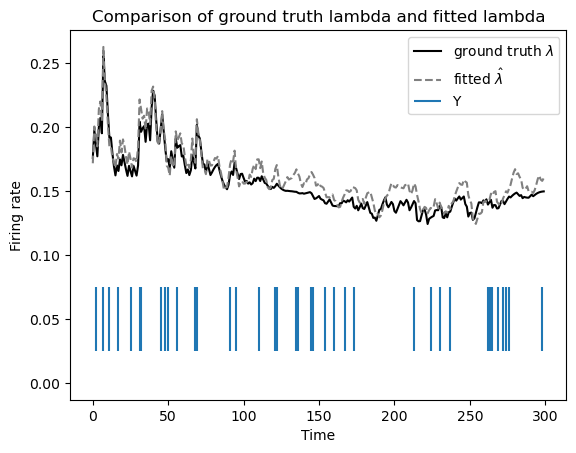

Loss of log_firing_rate_rcd: 0.4072878937403487
Loss of outputs: 0.4071325361728668


In [58]:
trial_to_plot = 11

model.get_ci()

plt.figure()
plt.plot(np.exp(log_firing_rate_rcd[trial_to_plot,-1,gt_neuron_params['npadding']:]), color='k', label='ground truth $\lambda$')
plt.plot(np.exp(model.log_firing_rate[-1].detach().cpu().numpy()[trial_to_plot, -1, :]), '--', color='grey', label='fitted $\hat{\lambda}$')
plt.eventplot(np.where(spikes[-1][trial_to_plot, -1, gt_neuron_params['npadding']:]>0), label='Y', lineoffsets=0.05, linelengths=0.05)
plt.xlabel('Time')
plt.ylabel('Firing rate')
plt.title('Comparison of ground truth lambda and fitted lambda')
plt.legend()
plt.show()

# Calculate the loss
loss_rcd = model.criterion(torch.tensor(log_firing_rate_rcd[trial_to_plot,-1,gt_neuron_params['npadding']:], device=device), 
                     model.spikes[-1][trial_to_plot, -1, gt_neuron_params['npadding']:])
loss_outputs = model.criterion(torch.tensor(model.log_firing_rate[-1].detach().cpu().numpy()[trial_to_plot, -1, :], device=device), 
                         model.spikes[-1][trial_to_plot, -1, gt_neuron_params['npadding']:])
print("Loss of log_firing_rate_rcd:", loss_rcd.item())
print("Loss of outputs:", loss_outputs.item())


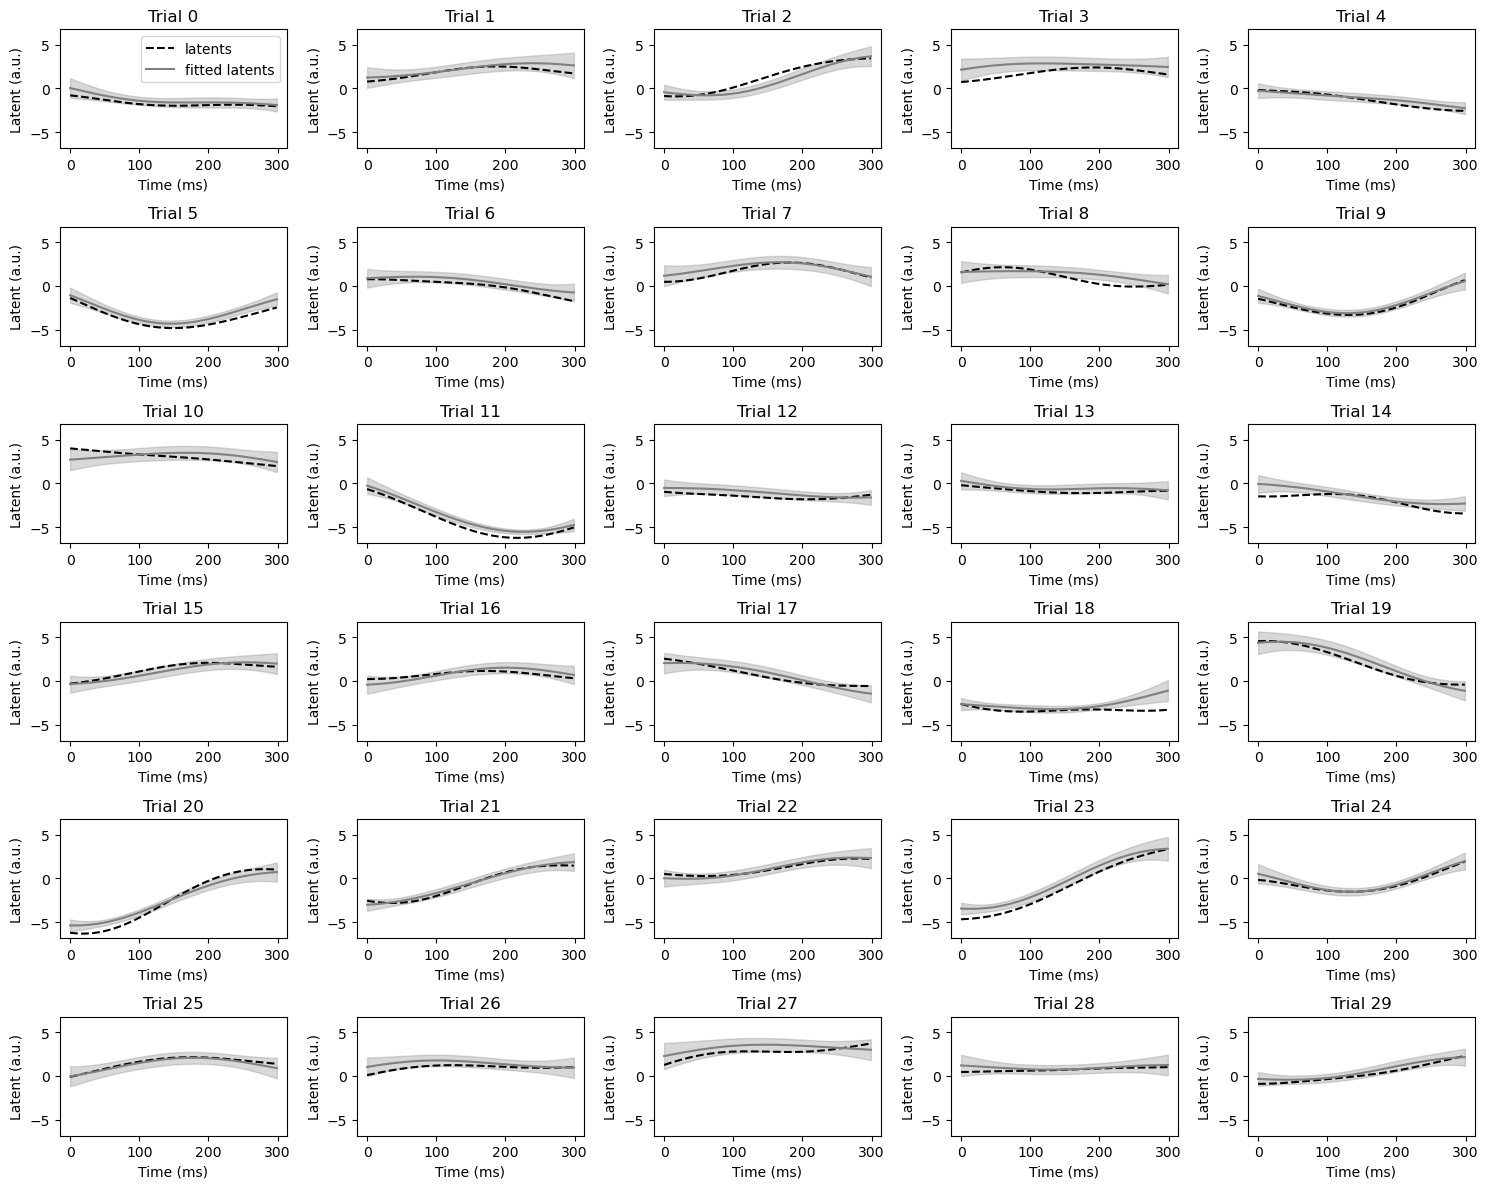

In [63]:
plt.figure(figsize=(15, 12))

# Get the maximum and minimum values of latents
latents_min = latents[:, 0, model.npadding:].min()
latents_max = latents[:, 0, model.npadding:].max()

for i in range(30):
    plt.subplot(6, 5, i+1)
    plt.plot(-latents[i, 0, model.npadding:], '--', label='latents', color='k')
    plt.plot(model.mu[i, 0, :].cpu().numpy(), label='fitted latents', color='grey')
    plt.fill_between(range(model.nt), 
                     model.lower_bound[i, 0, :].cpu().numpy(), 
                     model.upper_bound[i, 0, :].cpu().numpy(), 
                     alpha=0.3, color='grey')
    plt.xlabel('Time (ms)')
    plt.ylabel('Latent (a.u.)')
    plt.title(f'Trial {i}')
    plt.ylim(latents_min, latents_max)  # Set the same y-axis limits for each subplot
    if i==0:
        plt.legend()

plt.tight_layout()
plt.show()


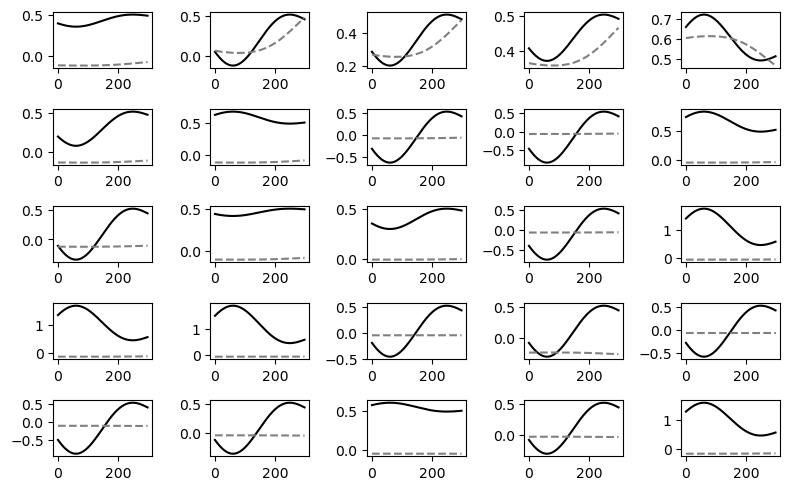

In [70]:
import matplotlib.pyplot as plt

trial = 8
fig, axs = plt.subplots(narea, narea, figsize=(8, 5))
for i in range(narea):
    for j in range(narea):
        axs[i, j].plot(time_varying_coef[i, j, trial, model.npadding:].T, 'k')
        axs[i, j].plot(model.time_varying_coef[i, j, trial, :].detach().cpu().numpy(),'--',color='grey')
        # axs[i, j].set_ylim([-0.2, 1.2])


plt.tight_layout()
plt.show()


In [61]:
for iarea in range(1, narea):
    print(f"weight from 0 to {iarea}: {model.latents_readout[0,iarea,0].item()}, {project_w[0,iarea,0]}")
    print(f"offest from 0 to {iarea}, {model.time_varying_coef_offset[0,iarea,0].item()}, {gt_latent_params['offset']}")
    
print(model.beta_inhomo[0])

weight from 0 to 1: -0.2990490198135376, 0.2901563896358586
offest from 0 to 1, 0.5441363453865051, 0.5
weight from 0 to 2: -0.1474706083536148, 0.1385637714836537
offest from 0 to 2, 0.505466103553772, 0.5
weight from 0 to 3: -0.0729634165763855, 0.060519451092237185
offest from 0 to 3, 0.48034530878067017, 0.5
weight from 0 to 4: 0.09751424938440323, -0.10294211170040311
offest from 0 to 4, 0.44792038202285767, 0.5
Parameter containing:
tensor([[[-1.4737],
         [-1.4647],
         [-1.4753],
         [-1.4685],
         [-1.4621]]], device='cuda:0', requires_grad=True)


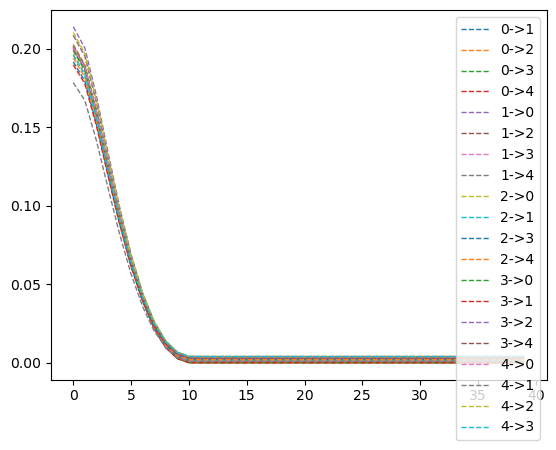

In [62]:
# for iarea in range(narea-1):
#     plt.plot(model.coupling_filters[iarea][iarea+1][:,:,0].mean(axis=0).detach().numpy().T)
eps = 1e-3

for iarea in range(narea):
    for jarea in range(narea):
        if iarea==jarea:
            continue
        plt.plot(model.coupling_filters[iarea][jarea][:,:,0].mean(axis=0).detach().cpu().numpy().T + eps*iarea, 
                 "--", lw=1, label=f'{iarea}->{jarea}')
plt.legend()

# (abondoned) Get baseline and coupling from real data

In [ ]:
# Load selected group_id
import pickle
with open('group_id_all_a_c/membership.pickle', 'rb') as handle:
    membership = pickle.load(handle)
with open('group_id_all_a_c/condition_ids.pickle', 'rb') as handle:
    condition_ids = pickle.load(handle)

probe_list = ['probeA', 'probeB', 'probeC', 'probeD', 'probeE', 'probeF']

# Load data
start_time = 0.0
end_time = 0.50
padding = 0.3
V1 = Allen_dataset(fps=1000,
                   start_time=start_time, 
                   end_time=end_time,
                   padding=padding,
#                    orientation=[0],
                   session_id=757216464,
                   selected_probes=['probeA', 'probeB', 'probeC', 'probeD', 'probeE', 'probeF'],
#                    temporal_frequency=[1,2,4],
                   stimulus_condition_id=[275, 277, 246, 255, 272, 248, 283, 266, 274, 276, 286, 271, 268, 270],
#                    stimulus_condition_id=[246, 247, 248, 249, 250, 251, 252, 253, 255, 256, 257, 258, 259, 260, 261, 
#                                           262, 263, 264, 265, 266, 267, 268, 269, 271, 272, 273, 274, 275, 276, 277,
#                                           278, 279, 280, 281, 282, 283, 284, 285, 286, 270],
                   stimulus_name='drifting_gratings')

# V1.get_lfp()
# V1.remove_padding(padding)
V1.get_trial_metric_per_unit_per_trial()
# V1.get_trial_metric_per_unit_per_trial(metric_type='spike_times')
V1.get_running(method="mine")

/home/qix/anaconda3/lib/python3.9/site-packages/allensdk/brain_observatory/ecephys/stimulus_table/naming_utilities.py:154: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  movie_rows = table[stim_colname].str.contains(movie_re, na=False)
/home/qix/anaconda3/lib/python3.9/site-packages/allensdk/brain_observatory/ecephys/ecephys_session.py:1315: UserWarning: Session includes invalid time intervals that could be accessed with the attribute 'invalid_times',Spikes within these intervals are invalid and may need to be excluded from the analysis.
  warnings.warn("Session includes invalid time intervals that could be accessed with the attribute 'invalid_times',"


In [ ]:
# The following hyperparameters turned out to be the best
num_f_refractory = 4
max_iter = 10
tau = 15
# coupling_filter_params = {'peaks_max':26, 'num':3, 'nonlinear':0.9}
coupling_filter_params = {'peaks_max':20.2, 'num':3, 'nonlinear':0.5}
num_basis_baseline = 20
penalty = 5e-1

################ No need to change below
probe_list = V1.selected_probes

running_model_list = []
stationary_model_list = []

for i, target_probe in tqdm(enumerate(probe_list)):
    select_trials = V1.running_trial_index
    model = GLM.PP_GLM(dataset=V1, 
                       select_trials=select_trials, 
                       membership=membership, 
                       condition_ids=condition_ids)
    model.add_effect('inhomogeneous_baseline', num=num_basis_baseline, apply_no_penalty=True)
    for j, input_probe in enumerate(probe_list):
        model.add_effect('coupling', probe_list[j], apply_no_penalty=True, **coupling_filter_params)
#     model.add_effect('refractory_additive', target_probe, tau=tau, num=num_f_refractory, apply_no_penalty=True)
    model.add_effect('trial_coef')
    model.fit_time_warping_baseline(target_probe, verbose=False, max_iter=max_iter, penalty=penalty)
    running_model_list.append(model)
    
    select_trials = V1.stationary_trial_index
    model = GLM.PP_GLM(dataset=V1, 
                       select_trials=select_trials, 
                       membership=membership, 
                       condition_ids=condition_ids)
    model.add_effect('inhomogeneous_baseline', num=num_basis_baseline, apply_no_penalty=True)
    for j, input_probe in enumerate(probe_list):
        model.add_effect('coupling', probe_list[j],apply_no_penalty=True, **coupling_filter_params)
#     model.add_effect('refractory_additive', target_probe, tau=tau, num=num_f_refractory, apply_no_penalty=True)
    model.add_effect('trial_coef')
    # model.fit_time_warping_baseline(target_probe, verbose=False, max_iter=max_iter, penalty=penalty)
    model.fit(target_probe, verbose=False, penalty=penalty)
    stationary_model_list.append(model)


6it [00:29,  4.93s/it]
